In [1]:
import numpy as np
import torch
import matplotlib
#matplotlib.use('PDF')
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['axes.linewidth'] = 0.5

In [2]:
class PROTON:
    
    """
    This class computes the 1d QCF, called a parton distribution function (PDF) for all flavors as a function of (x,Q2).
    Inputs:
        class instance mellin = contains routine to compute Mellin moments and inversions
        class instance alphaS = contains routine to evaluate the strong coupling constant at any scale
    """

    def __init__(self, flav_blind=True):

        self.flav_blind = flav_blind
        self.set_params()
        self.get_current_par_array()
        #self.setup(self.current_par)
  
    def set_params(self):

        self.params={}

                ### N1, N2, N3, sigma1, sigma2 (fixing as =sigma3), sigma3, alpha1, alpha2, alpha3, lambda, lambda2

        if self.flav_blind:
        
            self.params['TMD'] = torch.tensor([0.42, 0.022, 49e-05, -0.11, 10.16, 10.16, 0.21, 5.42, 2.27, 0.48, 0.095])

            self.features = ['TMD']

            self.fixed = {}

            self.fixed['TMD'] = [5]
        
        else:

            self.params['g']  = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
            self.params['u']  = torch.tensor([0.42, 0.022, 49e-05, -0.11, 10.16, 10.16, 0.21, 5.42, 2.27, 0.48, 0.095])
            self.params['ub'] = torch.tensor([0.42, 0.022, 49e-05, -0.11, 10.16, 10.16, 0.21, 5.42, 2.27, 0.48, 0.095])
            self.params['d']  = torch.tensor([0.42, 0.022, 49e-05, -0.11, 10.16, 10.16, 0.21, 5.42, 2.27, 0.48, 0.095])
            self.params['db'] = torch.tensor([0.42, 0.022, 49e-05, -0.11, 10.16, 10.16, 0.21, 5.42, 2.27, 0.48, 0.095])
            self.params['s']  = torch.tensor([0.42, 0.022, 49e-05, -0.11, 10.16, 10.16, 0.21, 5.42, 2.27, 0.48, 0.095])
            self.params['sb'] = torch.tensor([0.42, 0.022, 49e-05, -0.11, 10.16, 10.16, 0.21, 5.42, 2.27, 0.48, 0.095])
            self.params['c']  = torch.tensor([0.42, 0.022, 49e-05, -0.11, 10.16, 10.16, 0.21, 5.42, 2.27, 0.48, 0.095])
            self.params['cb'] = torch.tensor([0.42, 0.022, 49e-05, -0.11, 10.16, 10.16, 0.21, 5.42, 2.27, 0.48, 0.095])
            self.params['b']  = torch.tensor([0.42, 0.022, 49e-05, -0.11, 10.16, 10.16, 0.21, 5.42, 2.27, 0.48, 0.095])
            self.params['bb'] = torch.tensor([0.42, 0.022, 49e-05, -0.11, 10.16, 10.16, 0.21, 5.42, 2.27, 0.48, 0.095])

            self.features = ['g', 'u', 'ub', 'd', 'db', 's', 'sb', 'c', 'cb', 'b', 'bb']

            self.fixed = {}
            self.fixed['g'] = [i for i in range(len(self.params['g']))] ### not fitting gluon TMDs, fix params, fnp will return 0s
            self.fixed['u'] = [5]
            self.fixed['ub'] = [5]
            self.fixed['d'] = [5]
            self.fixed['db'] = [5]
            self.fixed['s'] = [5]
            self.fixed['sb'] = [5]
            self.fixed['c'] = [5]
            self.fixed['cb'] = [5]
            self.fixed['b'] = [5]
            self.fixed['bb'] = [5]
            
        
        self._parmin= torch.tensor([0, 0, 0, -0.5, 0, 0, 0 ,0, 0, 0, 0])
        self._parmax= torch.tensor([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])
        
    def get_current_par_array(self):
        
        self.current_par=[]
        self.order=[]
        self.parmin=[]
        self.parmax=[]
        for _ in self.features:
            for i in range(len(self.params[_])):
                if _ in self.fixed:
                    if i in self.fixed[_]: continue
                self.current_par.append(self.params[_][i])
                self.order.append(_)
                self.parmin.append(self._parmin[i])
                self.parmax.append(self._parmax[i])
        
        self.current_par=torch.tensor(self.current_par)
        self.parmin=torch.tensor(self.parmin)
        self.parmax=torch.tensor(self.parmax)
        
        return self.current_par

    def update_params(self,par_array):
        
        """
        This function is essential to pass a new array of parameters into the class during a fit.
        input:
            par_array: an array of the free parameters; len(par_array)=total number of free parameters across the flavors.
        """
        
        cnt=0
        for _ in self.features:
            for i in range(len(self.params[_])):
                if _ in self.fixed:
                    if i in self.fixed[_]: continue
                ### sigma2 is currently given as a parameter, however it is fixed as equal to sigma3, update both at the same time
                if i == 6:
                    self.params[_][5] = par_array[cnt]
                self.params[_][i]=par_array[cnt]
                cnt+=1

    def get_gfuncs(self, flav, x):

        xhat = torch.tensor(0.1)

        gfunc_format =  lambda xx, N, sigma, alpha : N * ( (torch.pow(xx, sigma) * torch.pow((1-xx), torch.square(alpha))) / (torch.pow(xhat, sigma) * torch.pow((1-xhat), torch.square(alpha))) )
        gfuncs = {}
        
        gfuncs['g1'] = gfunc_format(x, self.params[flav][0], self.params[flav][3], self.params[flav][6])
        gfuncs['g2'] = gfunc_format(x, self.params[flav][1], self.params[flav][4], self.params[flav][7])
        gfuncs['g3'] = gfunc_format(x, self.params[flav][2], self.params[flav][5], self.params[flav][8])
        
        return gfuncs
    
    def get_fnp(self, flav, x, bT):

        x = torch.tensor(x)[:,None].double()
        bT = torch.tensor(bT)[:,None].double()

        ### TMDs not implemented for gluon, return an array of 0s
        if flav == 'g':
            return torch.zeros((len(x),len(bT)))
        
        if self.flav_blind:
            flav = 'TMD'
            
        lambda1 = self.params[flav][9]
        lambda2 = self.params[flav][10]
        bTsq = torch.square(bT)

        gfuncs = self.get_gfuncs(flav,x)

        return ( ( gfuncs['g1'] * torch.exp(-gfuncs['g1']@bTsq.T/4) 
                  + torch.square(lambda1) * torch.square(gfuncs['g2']) * (1 - gfuncs['g2']@bTsq.T/4) * torch.exp(-gfuncs['g2']@bTsq.T/4)
                  + torch.square(lambda2) * gfuncs['g3'] * torch.exp(-gfuncs['g3']@bTsq.T/4) )
                / (gfuncs['g1'] + torch.square(lambda1) * torch.square(gfuncs['g2']) + torch.square(lambda2) * gfuncs['g3']) )


In [3]:
proton=PROTON(flav_blind=False)
min_pars = proton.parmin
max_pars = proton.parmax
flavs= proton.features
proton_TMDpdfs = {}
rng = np.random.default_rng()
for flav in flavs[1:]:
    proton_TMDpdfs[flav] = {}
    proton_TMDpdfs[flav][0]=proton.get_fnp(flav,[0.3],np.logspace(-3,2,50))

for flav in flavs[1:]:
    for i in range(1,6):
        new_pars = rng.uniform(low=min_pars, high=max_pars, size=min_pars.shape[0])
        proton.update_params(new_pars)
        proton_TMDpdfs[flav][i] = proton.get_fnp(flav,[0.3], np.logspace(-3,2,50))
print(proton_TMDpdfs['u'][0].dtype)

torch.float64


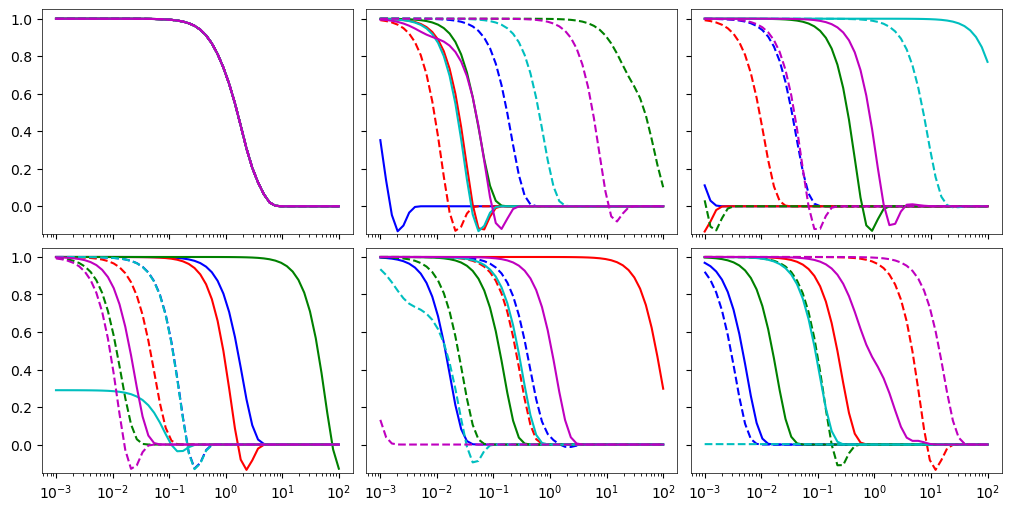

In [4]:
fig, axs = plt.subplots(2,3, layout='constrained', figsize=(10,5))
axs=axs.flatten()
disp=['b-','b--', 'r-', 'r--', 'g-', 'g--', 'c-', 'c--', 'm-', 'm--']
for flav, iflav in zip(flavs[1:], range(len(flavs[1:]))):
    for i in range(6):
        axs[i].plot(np.logspace(-3,2,50),proton_TMDpdfs[flav][i][0],disp[iflav])
for ax in axs: 
    ax.semilogx()
    ax.set_ylim(-0.15,1.05)
for ax in axs[0:3]: ax.set_xticklabels([])
for ax in axs[[1,2,4,5]]: ax.set_yticklabels([])
plt.show()

In [5]:
class NEUTRON(PROTON):
    def __init__(self, proton=None, flav_blind=True):
        super().__init__(flav_blind)
        if proton:
            self.update_params(proton.get_current_par_array())
        #### Flip the u and d elements from the proton case
        if not self.flav_blind:
            p_u = self.params['u']
            p_ub = self.params['ub']
            p_d = self.params['d']
            p_db = self.params['db']
            self.params['u'] = p_d
            self.params['ub'] = p_db
            self.params['d'] = p_u
            self.params['db'] = p_ub

####Should I add in a function to update based on proton params with appropriate u and d switching
    

In [6]:
neutron=NEUTRON(proton,flav_blind=False)

In [7]:
class PI_PLUS:
    def __init__(self):

        self.set_params()
        self.get_current_par_array()
        self.setup(self.current_par)

    def set_params(self):

        self.params = {}

        if self.flav_blind:
        
            self.params['TMD'] = torch.tensor([107e-05, 0.11, 11.62, 4.34, 0.0023, 0.19, 1.27, 0.16, 0.16])

            self.features = ['TMD']

            self.fixed = {}

        else:
        
            ### N4, N5, beta1, beta2, delta1, delta2, gamma1, gamma2, lambdaF
            self.params['g']  = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])
            self.params['u'] = torch.tensor([107e-05, 0.11, 11.62, 4.34, 0.0023, 0.19, 1.27, 0.16, 0.16])
            self.params['ub'] = torch.tensor([107e-05, 0.11, 11.62, 4.34, 0.0023, 0.19, 1.27, 0.16, 0.16])
            self.params['d'] = torch.tensor([107e-05, 0.11, 11.62, 4.34, 0.0023, 0.19, 1.27, 0.16, 0.16])
            self.params['db'] = torch.tensor([107e-05, 0.11, 11.62, 4.34, 0.0023, 0.19, 1.27, 0.16, 0.16])
            self.params['s'] = torch.tensor([107e-05, 0.11, 11.62, 4.34, 0.0023, 0.19, 1.27, 0.16, 0.16])
            self.params['sb'] = torch.tensor([107e-05, 0.11, 11.62, 4.34, 0.0023, 0.19, 1.27, 0.16, 0.16])
            self.params['c'] = torch.tensor([107e-05, 0.11, 11.62, 4.34, 0.0023, 0.19, 1.27, 0.16, 0.16])
            self.params['cb'] = torch.tensor([107e-05, 0.11, 11.62, 4.34, 0.0023, 0.19, 1.27, 0.16, 0.16])
            self.params['b'] = torch.tensor([107e-05, 0.11, 11.62, 4.34, 0.0023, 0.19, 1.27, 0.16, 0.16])
            self.params['bb'] = torch.tensor([107e-05, 0.11, 11.62, 4.34, 0.0023, 0.19, 1.27, 0.16, 0.16])
    
            self.features = ['g', 'u', 'ub', 'd', 'db', 's', 'sb', 'c', 'cb', 'b', 'bb']

            self.fix ={}

        self._parmin= torch.tensor([0, 0, 0, 0, 0, 0, 0 ,0, 0])
        self._parmax= torch.tensor([15, 15, 15, 15, 15, 15, 15, 15, 15])

    def get_current_par_array(self):
            
            self.current_par=[]
            self.order=[]
            self.parmin=[]
            self.parmax=[]
            for _ in self.features:
                for i in range(len(self.params[_])):
                    if _ in self.fixed:
                        if i in self.fixed[_]: continue
                    self.current_par.append(self.params[_][i])
                    self.order.append(_)
                    self.parmin.append(self._parmin[i])
                    self.parmax.append(self._parmax[i])
            
            self.current_par=torch.tensor(self.current_par)
            self.parmin=torch.tensor(self.parmin)
            self.parmax=torch.tensor(self.parmax)
            
            return self.current_par

    def update_params(self,par_array):
        
        """
        This function is essential to pass a new array of parameters into the class during a fit.
        input:
            par_array: an array of the free parameters; len(par_array)=total number of free parameters across the flavors.
        """
        
        cnt=0
        for _ in self.features:
            for i in range(len(self.params[_])):
                if _ in self.fixed:
                    if i in self.fixed[_]: continue
                self.params[_][i]=par_array[cnt]
                cnt+=1
    
    def get_gfuncs(self, flav, z):

        zhat = 0.5

        gfunc_format = lambda zz, N, beta, delta, gamma : N * ( ((torch.pow(zz, beta) + torch.square(delta)) * torch.pow((1-zz), torch.square(gamma))) / ((np.power(zhat, beta) + torch.square(delta)) * torch.pow((1-zhat),torch.square(gamma))) )

        gfuncs['g4'] = gfunc_format(zz, self.params[flav][0], self.params[flav][2], self.params[flav][4], self.params[flav][6])
        gfuncs['g5'] = gfunc_format(zz, self.params[flav][1], self.params[flav][3], self.params[flav][5], self.params[flav][7])
    
    def get_ff(self, flav, z, bT):

        z = torch.tensor(z)[:,None].double()
        bT = torch.tensor(bT)[:,None].double()

        ### TMDs not implemented for gluon, return an array of 0s
        if flav == 'g':
            return torch.zeros((len(x),len(bT)))
        
        if self.flav_blind:
            flav = 'TMD'
        
        lambdaF = self.params[flav][8]
        bTsq = torch.square(bT)

        gfuncs = self.get_gfuncs(flav,z)

        return ( ( gfuncs['g4'] * torch.exp(-gfuncs['g4']@bTsq.T/(4*torch.square(z)))
                  + lambdaF/torch.square(z) * torch.square(gfuncs['g5']) * (1 - gfuncs['g5']@bTsq.T/(4*torch.square(z))) * torch.exp(-gfuncs['g5']@bTsq.T/(4*torch.square(z))) )
                  / (gfuncs['g4'] + lambdaF / torch.square(z) * torch.square(gfuncs['g5'])) )
 

In [8]:
class PI_MINUS(PI_PLUS):
    def __init__(self, pi_plus=None, flav_blind=True):
        super().__init__(flav_blind)
        if pi_plus:
            self.update_params(pi_plus.get_current_par_array())
        #### Flip the u and d elements from the Pi+ case
        if not self.flav_blind:
            pp_u = self.params['u']
            pp_ub = self.params['ub']
            pp_d = self.params['d']
            pp_db = self.params['db']
            self.params['u'] = pp_d
            self.params['ub'] = pp_db
            self.params['d'] = pp_u
            self.params['db'] = pp_ub

In [9]:
###Try to vectorize the OPE element and convert everything to pytorch --> GPU enabled (we'll try Polaris)

In [11]:
print(np.linspace(0,5)[:,None].T.shape)
torch.linspace(0,5,50)[:,None].T.shape

(1, 50)


torch.Size([1, 50])